In [60]:
import os
import pandas as pd
import numpy as np

def load_process_all(folder_path):
    
    # Create an empty list to store DataFrames for each file
    dataframes = []

    # Loop through all CSV files and read them
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)

            # Handle timestamp
            df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
            df['timestamp'] = df['timestamp'].dt.floor('s')
            df.dropna(subset=['timestamp'], inplace=True)
            df = df.sort_values(by='timestamp')
            
            # Drop specified columns
            columns_to_drop = ['complete','coil_reversed', 'device', 'channel', 'hz', 'firmware', 'timestamp_tz',
                               'hour', 'Unnamed: 0.1', 'Unnamed: 0', 'event_id']
            df = df.drop(columns=columns_to_drop)
            df.dropna(subset=['active_power', 'apparent_power'], inplace=True)
            

            # Calculate Transients
            for i in range(1, 11):
                transient_name = f'Transient_{i}'
                df[transient_name] = df[f'peak_{i}'] - df['current']

            # Normalize Transients
            for i in range(1, 11):
                transient_name = f'Transient_{i}'
                norm_transient_name = f'normalized_transient_{i}'
                df[norm_transient_name] = df[transient_name] / np.sqrt((df[['Transient_1', 'Transient_2', 'Transient_3', 'Transient_4', 'Transient_5', 'Transient_6', 'Transient_7', 'Transient_8', 'Transient_9']] ** 2).sum(axis=1))

            # Calculate Mean of Transients
            df['mean_transient'] = df[['Transient_1', 'Transient_2', 'Transient_3', 'Transient_4', 'Transient_5', 'Transient_6', 'Transient_7', 'Transient_8', 'Transient_9', 'Transient_10']].mean(axis=1)

            # Calculate Standard Deviation of Transients
            df['std_transient'] = df[['Transient_1', 'Transient_2', 'Transient_3', 'Transient_4', 'Transient_5', 'Transient_6', 'Transient_7', 'Transient_8', 'Transient_9', 'Transient_10']].std(axis=1)

            # Calculate the mean of the highest 7 transients
            df['mean_top7_transient'] = df[['Transient_1', 'Transient_2', 'Transient_3', 'Transient_4', 'Transient_5', 'Transient_6', 'Transient_7', 'Transient_8', 'Transient_9', 'Transient_10']].apply(lambda row: row.nlargest(7).mean(), axis=1)
            
            
            # Calculate cumulative energy
            df['cumulative_energy'] = df['energy'].cumsum()

            # Calculate the Power Factor for each event. set the power factor to None where the apparent power is zero
            df['power_factor'] = df.apply(
                lambda row: row['active_power'] / row['apparent_power'] if row['apparent_power'] != 0 else None, axis=1)

            # Assign a column with the name of the file (e.g., sensor_0, sensor_1, etc.)
            df['sensor_name'] = os.path.splitext(file_name)[0]
            
            # Append the cleaned DataFrame to the list
            dataframes.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(dataframes, ignore_index=True)
    # converting wh to kwh
    combined_df['energy'] = combined_df['energy'] / 1000

    return combined_df


In [61]:
folder_path = 'data_set_1'
df = load_process_all(folder_path)

In [62]:
df['evt_type'].value_counts()

evt_type
5    51188
1    11365
2     9804
Name: count, dtype: int64

##### ASSUMING 1 REPRESNT ON, 2 REPRESNT OFF, 5 REPRESENT KEEP ALIVE

In [63]:
# Define a dictionary to map values
event_type_mapping = {1: 'ON', 2: 'OFF', 5: 'KEEP ALIVE'}

# Use the map method to update the 'event_type' column
df['evt_type'] = df['evt_type'].map(event_type_mapping)


In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_sensor_efficiency(df, sensor_names):
    """
    Visualize the power factor distribution for each sensor (appliance).

    Parameters:
    df (DataFrame): DataFrame containing 'power_factor', 'evt_type', and 'sensor_name'.
    sensor_names (list): List of sensor names to visualize.

    Returns:
    None: This function generates a plot.
    """
    # Filter the DataFrame for the selected sensor names
    df_filtered = df[df['sensor_name'].isin(sensor_names)]
    
    # Set the style of seaborn
    sns.set_style("whitegrid")

    # Initialize the matplotlib figure
    plt.figure(figsize=(14, 6))

    # Create a boxplot for each sensor
    sns.boxplot(x='sensor_name', y='power_factor', hue='evt_type', data=df_filtered, palette="Set3")

    # Set the title and labels
    plt.title('Power Factor Distribution by Sensor (Appliance)')
    plt.xlabel('Sensor (Appliance) Name')
    plt.ylabel('Power Factor')
    plt.xticks(rotation=45)  # Rotate the x labels for better readability

    # Place the legend outside the plot
    plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
    plt.show()


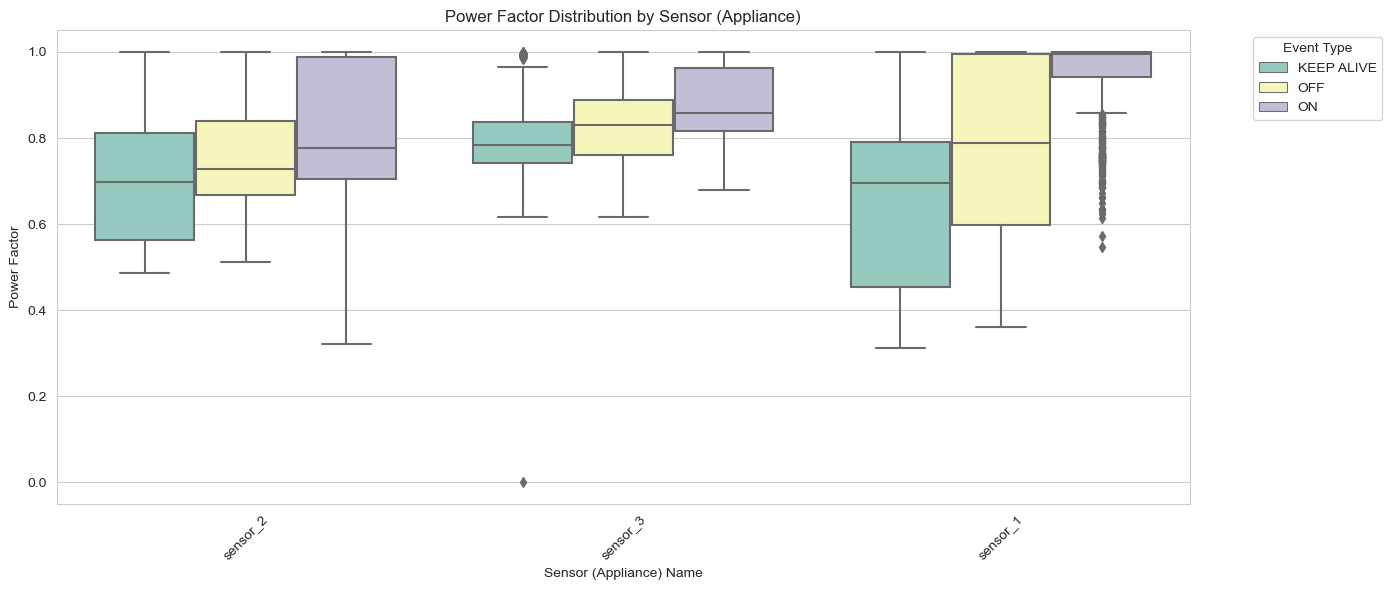

In [75]:
sensor_list = ['sensor_1', 'sensor_2', 'sensor_3']  
visualize_sensor_efficiency(df, sensor_list)



1. **Variability in Power Factor**: There is variability in power factor across different sensors and event types. The median power factor, as well as the spread of values, varies for each sensor, which could indicate differences in appliance efficiency.

2. **Consistency**: Some sensors show a consistent power factor (narrow boxes), suggesting stable performance, while others have a wide interquartile range, indicating variability in efficiency during operation.

3. **Efficiency Indicators**: A median power factor close to 1 is an indicator of high efficiency. Sensors that consistently show a power factor near 1, regardless of the event type, are likely operating efficiently.

4. **Potential Inefficiency**: Sensors with a median power factor significantly below 1 may be associated with less efficient appliances, especially if this trend is consistent across 'ON' and 'OFF' events.

5. **Outliers**: The presence of outliers suggests occasional deviations from typical performance. These could be instances where the appliance efficiency significantly drops or spikes, which may require further investigation.

6. **Event Type Impact**: The power factor appears to differ during 'ON' and 'OFF' events for some sensors, which may provide insights into the appliances' performance during different operational states.

7. **Stability During Keep Alive**: The 'KEEP ALIVE' events generally show less variation in power factor, suggesting that when appliances are not actively switching states, their power factor remains more stable.

Overall, the boxplot suggests that there are notable differences in how appliances consume power in this environment. Appliances corresponding to sensors with lower or more variable power factors may need attention to improve overall energy efficiency. Further investigation into the reasons behind these patterns could help optimize power usage, reduce costs, or guide decisions about maintenance and equipment upgrades.